In [1]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import re
from PIL import Image  #Python Imaging Library
import cv2
import copy
import zipfile
import gdown
import albumentations as A
import random
import datetime
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint, TensorBoard

In [2]:
# correr esta célula apenas se o dataset estiver na drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Este pedaço de código é destinado a aceder à pasta do dataset, portanto pode ser diferente de user para user
%cd /content/drive/MyDrive/Colab Notebooks/MarsSampleLocalization_Dataset

/content/drive/MyDrive/Colab Notebooks/MarsSampleLocalization_Dataset


### **Primeiro foi feito tudo para a parte real do dataset e só depois é que se juntou a parte sintética. Daí algumas funções criadas terem sido adaptadas para a parte sintética**

## **Primeiro passo**: Mudar os endereços das imagens para algo acessível







In [4]:
# função que devolve os novos paths das imagens, para que sejam mais acessíveis

def list_from_darknetlabels(image_type, set_type):

  f = open('./train_images/darknet_labels/' + image_type + '_' + set_type + '.txt', 'r')
  lines_list = f.readlines()
  f.close()

  vector = []

  for line in lines_list:

      my_regex = re.compile("((?<=datasets/).*).png")   # positive lookbehind
      m_1 = my_regex.search(line)
      m_2 = m_1.group(0)
      path = './' + m_2
      vector.append(path)

  return vector

In [5]:
# para as imagens de train e valid reais, respetivamente

real_train_list = list_from_darknetlabels('real', 'train')
real_valid_list = list_from_darknetlabels('real', 'valid')
real_train_list

['./train_images/real/train/Treal_N1.png',
 './train_images/real/train/Treal_N2.png',
 './train_images/real/train/Treal_N3.png',
 './train_images/real/train/Treal_N4.png',
 './train_images/real/train/Treal_N6.png',
 './train_images/real/train/Treal_N7.png',
 './train_images/real/train/Treal_N8.png',
 './train_images/real/train/Treal_N9.png',
 './train_images/real/train/Treal_N10.png',
 './train_images/real/train/Treal_N11.png',
 './train_images/real/train/Treal_N12.png',
 './train_images/real/train/Treal_N13.png',
 './train_images/real/train/Treal_N14.png',
 './train_images/real/train/Treal_N15.png',
 './train_images/real/train/Treal_N16.png',
 './train_images/real/train/Treal_N17.png',
 './train_images/real/train/Treal_N18.png',
 './train_images/real/train/Treal_N19.png',
 './train_images/real/train/Treal_N20.png',
 './train_images/real/train/Treal_N22.png',
 './train_images/real/train/Treal_N23.png',
 './train_images/real/train/Treal_N24.png',
 './train_images/real/train/Treal_N25.pn

PNG (1024, 768) L


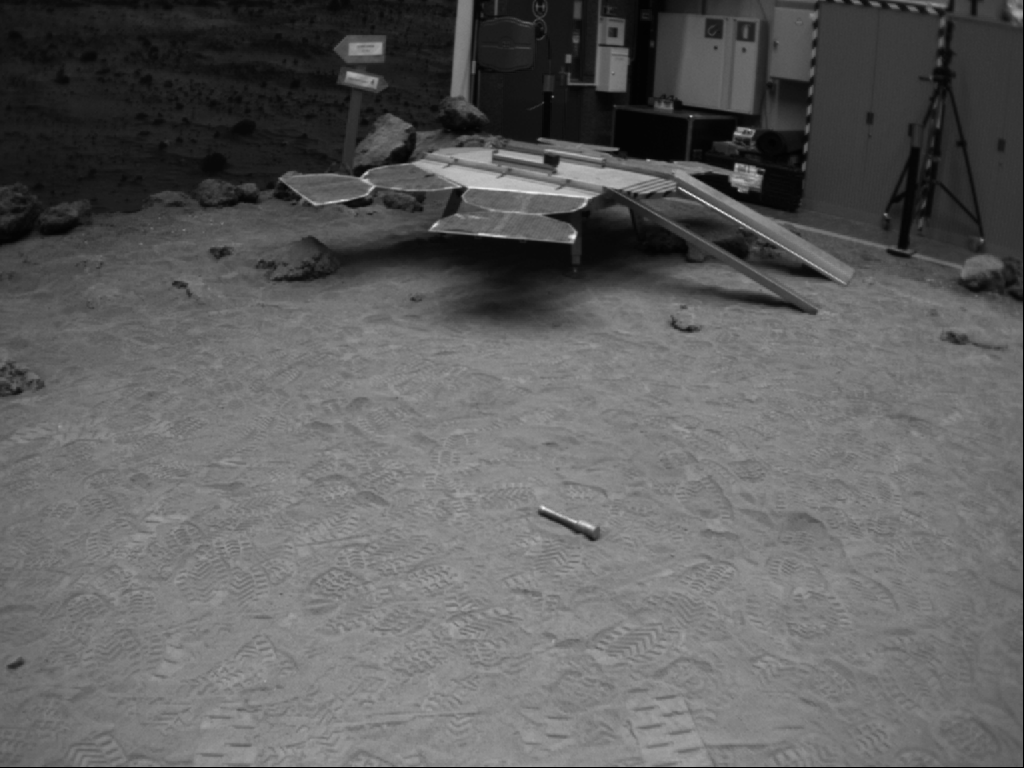

In [6]:
# apenas uma função para ajudar a ter uma visualização da imagem em causa

def imgpath_to_image(path):

    img = Image.open(path)
    return img

img = imgpath_to_image(real_train_list[0])
print(img.format, img.size, img.mode)
img

## **Segundo passo**: Feature extraction
As imagens alteradas farão parte, na forma de tensores, de X_train_real e X_val_real

In [7]:
# guardar as shapes das imagens de train_real e valid_real, que são iguais, antes de darem resize

image = cv2.imread(real_valid_list[0]) #, cv2.IMREAD_GRAYSCALE) é necessário  para ter apenas um canal e não 3 canais de cor
shape_before = image.shape
shape_before

(768, 1024, 3)

In [8]:
# função que vai criar X_train e X_val, em forma de np.array

def img_to_array_modified(vector):

  X = []

  for img_path in vector:

      img_arr = cv2.imread(img_path) ################, cv2.IMREAD_GRAYSCALE)
      img_arr = cv2.resize(img_arr,(512,384))  # alterar aqui os valores da shape em função do ratio
      img_normalized = cv2.normalize(img_arr, None, -1, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
      X.append(img_normalized)

  return np.array(X)

In [9]:
# criar X_train_real e X_val_real e verificar a shape atual de ambos

X_train_real = img_to_array_modified(real_train_list)
X_val_real = img_to_array_modified(real_valid_list)

shape_after = (X_train_real.shape[1], X_train_real.shape[2], X_train_real.shape[3])

print(X_train_real.shape, X_val_real.shape)

(49, 384, 512, 3) (6, 384, 512, 3)


In [10]:
X_train_real[0]

array([[[-0.9118943 , -0.9118943 , -0.9118943 ],
        [-0.90308374, -0.90308374, -0.90308374],
        [-0.8854626 , -0.8854626 , -0.8854626 ],
        ...,
        [-0.03083706, -0.03083706, -0.03083706],
        [-0.08370049, -0.08370049, -0.08370049],
        [-0.55947137, -0.55947137, -0.55947137]],

       [[-0.8854626 , -0.8854626 , -0.8854626 ],
        [-0.876652  , -0.876652  , -0.876652  ],
        [-0.85022026, -0.85022026, -0.85022026],
        ...,
        [-0.11013221, -0.11013221, -0.11013221],
        [-0.12775335, -0.12775335, -0.12775335],
        [-0.55947137, -0.55947137, -0.55947137]],

       [[-0.8414097 , -0.8414097 , -0.8414097 ],
        [-0.83259916, -0.83259916, -0.83259916],
        [-0.8061674 , -0.8061674 , -0.8061674 ],
        ...,
        [-0.2422908 , -0.2422908 , -0.2422908 ],
        [-0.2422908 , -0.2422908 , -0.2422908 ],
        [-0.5770925 , -0.5770925 , -0.5770925 ]],

       ...,

       [[-0.2070485 , -0.2070485 , -0.2070485 ],
        [-0

##**Terceiro passo:** Preparar as dataframe de onde se obtêm os valores que formam as bounding boxes das imagens de X_train_real e X_val_real:

Estas bounding boxes terão o formato usado com YOLO, i.e.:
**[x_centroid, y_centroid, width, height]** normalizados

De momento têm formato Albumentations: [x_min, y_min, x_max, y_max], tudo normalizado

In [11]:
# preparar a dataframe a partir do csv file que contém as coordenadas das
# bounding boxes de train e val, adaptado para sintético e real
# os nomes das imagens .png serão o índice da df e faremos drop da coluna label

def prepare_df(image_type):

  if image_type == 'real':
    df = pd.read_csv('./train_images/real/real_scene.csv')

  else:
    df = pd.read_csv('./train_images/synthetic/synthetic_scene.csv')

  df.set_index('image', inplace=True)
  df.drop('label', axis=1, inplace=True)

  return df

In [12]:
df_real = prepare_df('real')
df_real

,xmin,ymin,xmax,ymax
image,,,,
Treal_N11.png,418.660017,40.017738,461.220283,53.640798
Treal_N1.png,529.316708,497.241685,604.222776,545.773836
Treal_N12.png,476.541978,421.463415,542.935993,464.035477
Treal_N13.png,854.477140,292.895787,892.781380,323.547672
Treal_N10.png,413.552785,182.208426,458.666667,206.900222
Treal_N14.png,570.174564,482.767184,660.402328,545.773836
Treal_N15.png,525.060682,209.454545,578.686617,249.472284
Treal_N16.png,503.780549,70.669623,550.596841,90.252772
Treal_N17.png,18.593516,193.277162,52.641729,217.117517


In [13]:
# shape_before = (768, 1024, 3), calculado anteriormente
# cuidado para não correr antes das células reais
# a célula mais à frente que guarda em "shape_before" a shape das sintéticas

def normalize_df(df):

  for i, column in enumerate(df.columns):

      if column == 'xmin' or column == 'xmax':
        df[column] /= shape_before[1]  # normaliza-se os valores

      else:
        df[column] /= shape_before[0]

  return df

In [14]:
df_real = normalize_df(df_real)
df_real

,xmin,ymin,xmax,ymax
image,,,,
Treal_N11.png,0.408848,0.052106,0.450410,0.069845
Treal_N1.png,0.516911,0.647450,0.590061,0.710643
Treal_N12.png,0.465373,0.548780,0.530211,0.604213
Treal_N13.png,0.834450,0.381375,0.871857,0.421286
Treal_N10.png,0.403860,0.237251,0.447917,0.269401
Treal_N14.png,0.556811,0.628603,0.644924,0.710643
Treal_N15.png,0.512755,0.272727,0.565124,0.324834
Treal_N16.png,0.491973,0.092018,0.537692,0.117517
Treal_N17.png,0.018158,0.251663,0.051408,0.282705


## **Quarto passo**: Criar y_train e y_val a partir dos valores alterados e ajustados da dataframe

In [15]:
# a função que se segue a esta célula foi generalizada para a parte sintética do dataset,
# sendo por isso necessário correr previamente o seguinte código

synthetic_train_list = list_from_darknetlabels('synthetic', 'train')
synthetic_valid_list = list_from_darknetlabels('synthetic', 'valid')

In [16]:
# como as imagens de train e valid estão misturadas na dataframe, é necessário
# separá-las em duas dataframes distintas, df_train e df_val

# função que separa a dataframe em duas

def separate_df(list):

  image_index = []

  for line in list:

      if list == real_valid_list or list == synthetic_valid_list:
        reg_ex = "((?<=valid/).*)"

      else:
        reg_ex = "((?<=train/).*)"

      my_regex = re.compile(reg_ex)
      m_1 = my_regex.search(line)
      m_2 = m_1.group(0)
      image_index.append(m_2)

  if list == real_valid_list or list == real_train_list:
    df = df_real.loc[image_index]

  else:
    df = df_synthetic.loc[image_index]

  return df

In [17]:
# cria-se as dataframes df_train_real e df_val_real

df_train_real = separate_df(real_train_list)
df_val_real = separate_df(real_valid_list)
df_val_real[:2]

,xmin,ymin,xmax,ymax
image,,,,
Treal_N5.png,0.660718,0.876940,0.750494,0.962306
Treal_N21.png,0.938357,0.307095,0.965789,0.342572


In [18]:
df_train_real[:5]

,xmin,ymin,xmax,ymax
image,,,,
Treal_N1.png,0.516911,0.647450,0.590061,0.710643
Treal_N2.png,0.708100,0.486696,0.847750,0.620843
Treal_N3.png,0.487947,0.638581,0.570942,0.733925
Treal_N4.png,0.558474,0.840355,0.652405,0.947894
Treal_N6.png,0.566786,0.347007,0.659055,0.414634


In [19]:
# a partir das dataframes criadas, prepara-se o y_train e y_val, em forma de np.array
# função que cria o y_train e y_val, dependendo do input df que se lhe dá

def y_set(df):

  y = []

  for i in range(df.shape[0]):
      vector = []

      for j in range(df.shape[1]):
          vector.append(df.iloc[i,j])

      y.append(vector)

  return np.array(y)

In [20]:
# esta função serve para transformar uma bounding box com coordenadas em formato Albu
# para uma bounding box em formato YOLO

def bboxAlbu_to_YOLO(y_set):

    y_YOLO = []

    for bbox in y_set:

        vector = [0,0,0,0]

        vector[0] = (bbox[0] + bbox[2]) / 2  # (xmin + xmax) / 2
        vector[1] = (bbox[1] + bbox[3]) / 2  # (ymin + ymax) / 2
        vector[2] = bbox[2] - bbox[0]        # (xmax - xmin)
        vector[3] = bbox[3] - bbox[1]        # (ymax - ymin)

        y_YOLO.append(vector)

    return np.array(y_YOLO)

In [21]:
# esta função executa o contrário da anterior: transforma uma bounding box com
#coordenadas em formato YOLO para uma bounding box em formato Albu

def bboxYOLO_to_Albu(y_set):

    y_Albu = []

    for bbox in y_set:

        vector = [0,0,0,0]

        vector[0] = bbox[0] - bbox[2] / 2
        vector[1] = bbox[1] - bbox[3] / 2
        vector[2] = bbox[2] + vector[0]
        vector[3] = bbox[3] + vector[1]

        y_Albu.append(vector)

    return np.array(y_Albu)

In [22]:
# criar y_train_real e y_val_real, verificando a shape de ambos

y_train_real = bboxAlbu_to_YOLO(y_set(df_train_real))
y_val_real = bboxAlbu_to_YOLO(y_set(df_val_real))
print(y_train_real.shape, y_val_real.shape)

y_train_real[:2], y_val_real[:2]

(49, 4) (6, 4)


(array([[0.55348608, 0.67904656, 0.07315046, 0.0631929 ],
        [0.77792498, 0.5537694 , 0.13965087, 0.13414634]]),
 array([[0.70560578, 0.91962306, 0.08977556, 0.08536585],
        [0.95207294, 0.3248337 , 0.02743142, 0.03547672]]))

**------ Apenas a verificar se está a construir a bounding box num dos exemplos do train -------**

In [23]:
X_train_real[0]

array([[[-0.9118943 , -0.9118943 , -0.9118943 ],
        [-0.90308374, -0.90308374, -0.90308374],
        [-0.8854626 , -0.8854626 , -0.8854626 ],
        ...,
        [-0.03083706, -0.03083706, -0.03083706],
        [-0.08370049, -0.08370049, -0.08370049],
        [-0.55947137, -0.55947137, -0.55947137]],

       [[-0.8854626 , -0.8854626 , -0.8854626 ],
        [-0.876652  , -0.876652  , -0.876652  ],
        [-0.85022026, -0.85022026, -0.85022026],
        ...,
        [-0.11013221, -0.11013221, -0.11013221],
        [-0.12775335, -0.12775335, -0.12775335],
        [-0.55947137, -0.55947137, -0.55947137]],

       [[-0.8414097 , -0.8414097 , -0.8414097 ],
        [-0.83259916, -0.83259916, -0.83259916],
        [-0.8061674 , -0.8061674 , -0.8061674 ],
        ...,
        [-0.2422908 , -0.2422908 , -0.2422908 ],
        [-0.2422908 , -0.2422908 , -0.2422908 ],
        [-0.5770925 , -0.5770925 , -0.5770925 ]],

       ...,

       [[-0.2070485 , -0.2070485 , -0.2070485 ],
        [-0

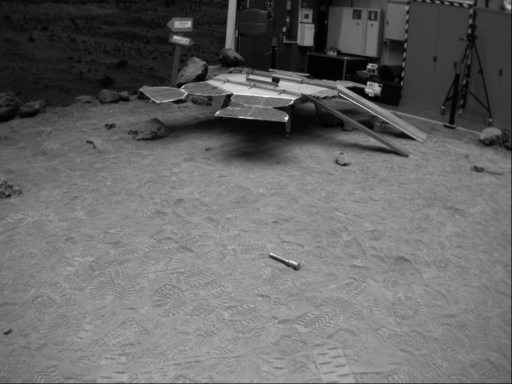

In [24]:
pil_img = tf.keras.utils.array_to_img(X_train_real[0])
pil_img

In [25]:
# esta função também pode servir para mostrar uma imagem sem bounding box, basta colocar bbox = []

def show_image_bbox(X_set, y_set, index, new_img_path):

  y_set_Albu = bboxYOLO_to_Albu(y_set)

  X_arr = X_set[index]
  bbox = y_set_Albu[index]

  # os valores da bbox têm de entrar normalizados
  shape_after = X_arr.shape

  bbox_ = copy.deepcopy(bbox)
  pil_img = tf.keras.utils.array_to_img(X_arr)  # esta função tira a normalização do array (não tem muito problema dado que esta função é apenas para demonstração, no modelo entram os valores normalizados)

  tf.keras.utils.save_img(new_img_path, pil_img)

  if len(bbox_) != 0:
    bbox_[0] *= shape_after[1]
    bbox_[1] *= shape_after[0]
    bbox_[2] *= shape_after[1]
    bbox_[3] *= shape_after[0]

    start_point = (int(bbox_[0]), int(bbox_[1]))
    end_point = (int(bbox_[2]), int(bbox_[3]))

  color = (255,0,0)  # RGB, fica vermelho desta forma
  thickness = 1

  image = cv2.imread('./' + new_img_path)

  if len(bbox_) != 0:
    image = cv2.rectangle(image, start_point, end_point, color, thickness)  # tem de se usar valores inteiros aqui
    image = cv2.putText(image, 'sample', (int(bbox_[0]), int(bbox_[1] - 3)), 0, 0.3, (255,0,0), 1)

  final_img = tf.keras.utils.array_to_img(image)

  return final_img

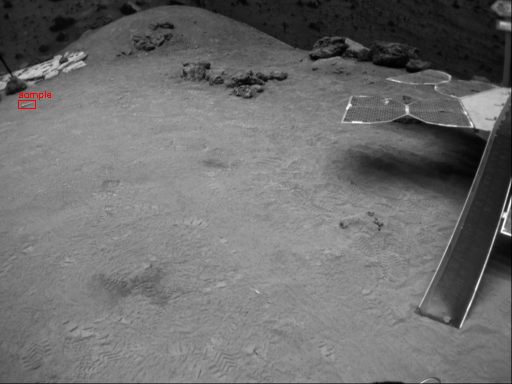

In [26]:
show_image_bbox(X_train_real, y_train_real, 5, 'tinyTreal_N1.png')

## **Quinto passo**: Criar X_train e X_val, ao adicionar a X_train_real e X_val_real a parte sintética do dataset

**--- 1º ---**

In [27]:
# código já corrido lá em cima

synthetic_train_list = list_from_darknetlabels('synthetic', 'train')
synthetic_valid_list = list_from_darknetlabels('synthetic', 'valid')

**--- 2º ---**

In [28]:
# guardar as shapes das imagens de train e valid, que são iguais, antes de darem resize

image = cv2.imread(synthetic_valid_list[0])
shape_before = image.shape
shape_before

(720, 1280, 3)

In [29]:
X_train_syn = img_to_array_modified(synthetic_train_list)
X_val_syn = img_to_array_modified(synthetic_valid_list)

In [30]:
shape_after = (X_train_syn.shape[1], X_train_syn.shape[2], X_train_syn.shape[3])

print(X_train_syn.shape, X_val_syn.shape)

(542, 384, 512, 3) (60, 384, 512, 3)


**--- 3º ---**

In [31]:
df_synthetic = prepare_df('synthetic')
df_synthetic[:2]

,xmin,ymin,xmax,ymax
image,,,,
Tsyn_N104.png,743.652653,375.965074,773.645762,385.670956
Tsyn_N463.png,761.662246,373.691038,793.351017,396.332547


In [32]:
df_synthetic = normalize_df(df_synthetic)
df_synthetic[:2]

,xmin,ymin,xmax,ymax
image,,,,
Tsyn_N104.png,0.580979,0.522174,0.604411,0.535654
Tsyn_N463.png,0.595049,0.519015,0.619805,0.550462


**--- 4º ---**

In [33]:
df_train_syn = separate_df(synthetic_train_list)
df_val_syn = separate_df(synthetic_valid_list)
df_val_syn[:2]

,xmin,ymin,xmax,ymax
image,,,,
Tsyn_N9.png,0.622498,0.584701,0.657695,0.594517
Tsyn_N15.png,0.316770,0.542983,0.339545,0.556480


In [34]:
y_train_syn = bboxAlbu_to_YOLO(y_set(df_train_syn))
y_val_syn = bboxAlbu_to_YOLO(y_set(df_val_syn))
print(y_train_syn.shape, y_val_syn.shape)

y_train_syn[:2], y_val_syn[:2]

(542, 4) (60, 4)


(array([[0.61732229, 0.50187883, 0.02967564, 0.01349693],
        [0.58730159, 0.57488497, 0.02346446, 0.01717791]]),
 array([[0.64009662, 0.5896089 , 0.03519669, 0.00981595],
        [0.32815735, 0.5497316 , 0.02277433, 0.01349693]]))

**--- 5º ---**

In [35]:
# criar o X_train, X_val, y_train e y_val final com as imagens reais e sintéticas

X_train = np.concatenate([X_train_real, X_train_syn])
y_train = np.concatenate([y_train_real, y_train_syn])
X_val = np.concatenate([X_val_real, X_val_syn])
y_val = np.concatenate([y_val_real, y_val_syn])

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(591, 384, 512, 3) (591, 4) (66, 384, 512, 3) (66, 4)


**----- Apenas a verificar se está a construir a bounding box num dos exemplos do synthetic -----**

In [36]:
X_train[49]

array([[[-0.717647  , -0.46666664, -0.01960779],
        [-0.5215686 , -0.11372544,  0.52941185],
        [-0.6705882 , -0.30980387,  0.30196086],
        ...,
        [-0.717647  , -0.4352941 ,  0.01176477],
        [-0.61568624, -0.32549015,  0.15294124],
        [-0.77254903, -0.47450978, -0.02745092]],

       [[-0.61568624, -0.27843133,  0.2705883 ],
        [-0.42745095, -0.02745092,  0.6000001 ],
        [-0.55294114, -0.16078426,  0.50588244],
        ...,
        [-0.4823529 , -0.07450975,  0.49019617],
        [-0.6549019 , -0.27843133,  0.26274517],
        [-0.63921565, -0.23921564,  0.309804  ]],

       [[-0.7098039 , -0.372549  ,  0.16862752],
        [-0.34117642, -0.01960779,  0.48235303],
        [-0.47450978, -0.1058823 ,  0.5137256 ],
        ...,
        [-0.6235294 , -0.30980387,  0.2470589 ],
        [-0.717647  , -0.33333328,  0.2470589 ],
        [-0.52941173, -0.09803917,  0.55294126]],

       ...,

       [[-0.8901961 , -0.717647  , -0.44313723],
        [-0

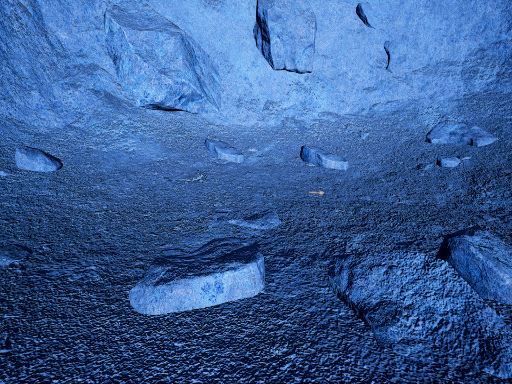

In [37]:
pil_img = tf.keras.utils.array_to_img(X_train[49])
pil_img

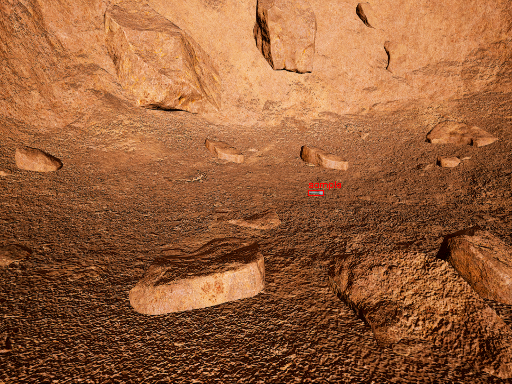

In [38]:
show_image_bbox(X_train, y_train, 49, 'tinyTsyn_N104.png') # está a perder a normalização por causa do cv2.imread()

## **Sexto passo:** Data Augmentation com albumentations.ai
(está menos confuso e melhor organizado)

**Fazer uma pipeline de transformações, para train e valid:**

In [39]:
# antes de adicionar as imagens transformadas aos conjuntos, as shapes de X_train e X_valid são
# respetivamente (591, 224, 224, 3), (66, 224, 224, 3)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(591, 384, 512, 3) (591, 4) (66, 384, 512, 3) (66, 4)


In [40]:
def transform_images(X_set, bbox_set, transform):

    bbox_set = list(bbox_set)
    X_transformed = []
    bbox_transformed = []

    for i in range(len(bbox_set)):

        bbox_set[i] = list(bbox_set[i])
        bbox_set[i].append('sample')

    for i in range(X_set.shape[0]):

        transformed = transform(image=X_set[i], bboxes=[bbox_set[i]])
        transformed_image = transformed['image']
        transformed_bbox = transformed['bboxes']

        X_transformed.append(transformed_image)
        bbox_transformed.append(transformed_bbox)

    for i in range(len(bbox_transformed)):

        if len(bbox_transformed[i]) != 0:
          bbox_transformed[i] = list(bbox_transformed[i][0])
          bbox_transformed[i].remove('sample')

    # retirar as imagens onde o tubo não está presente

    X_train_transf = []
    y_train_transf = []

    for i, bbox in enumerate(bbox_transformed):

        if len(bbox) != 0:
          X_train_transf.append(X_transformed[i])
          y_train_transf.append(bbox)

    return np.array(X_train_transf), np.array(y_train_transf)

In [41]:
# efetuamos três transformações diferentes em todo o X_train e y_train
# no final, fazemos concat dos novos elementos de X_train e y_train

def apply_transformations_and_concat(X_set, y_set):

    reshape_values = (X_set.shape[1], X_set.shape[2])

    random.seed(40)
    transform_1 = A.Compose([A.RandomCrop(width=192, height=144),
                             A.augmentations.geometric.resize.Resize(
                             height = reshape_values[0], width = reshape_values[1])
			                       ],
                             bbox_params=A.BboxParams(format='yolo'))


    random.seed(41)
    transform_2 = A.Compose([A.augmentations.transforms.GaussNoise(
                             var_limit=0.05, mean=0.3, per_channel=True, p=1),
                             ],
                             bbox_params=A.BboxParams(format='yolo'))

    random.seed(42)
    transform_3 = A.Compose([A.augmentations.geometric.transforms.Affine(scale=1.5, p=1),
			                       A.augmentations.geometric.rotate.Rotate(
                             limit=360, rotate_method='largest_box', crop_border=False, p=1)
                             ],
                             bbox_params=A.BboxParams(format='yolo'))

    transformed_X_set_1, transformed_y_set_1 = transform_images(X_set, y_set, transform_1)
    transformed_X_set_2, transformed_y_set_2 = transform_images(X_set, y_set, transform_2)
    transformed_X_set_3, transformed_y_set_3 = transform_images(X_set, y_set, transform_3)

    # para conseguir este concat, é necessário terem todas as mesma shape que X_set

    X_set_final = np.concatenate([X_set,
                                  transformed_X_set_1,
                                  transformed_X_set_2
                                  ,
                                  transformed_X_set_3,
                                  ])

    y_set_final = np.concatenate([y_set,
                                  transformed_y_set_1,
                                  transformed_y_set_2
                                  ,
                                  transformed_y_set_3,
                                  ])

    return X_set_final, y_set_final

In [42]:
X_train_final, y_train_final = apply_transformations_and_concat(X_train, y_train)
X_val_final, y_val_final = apply_transformations_and_concat(X_val, y_val)

print(X_train_final.shape, y_train_final.shape)
print(X_val_final.shape, y_val_final.shape)

(1966, 384, 512, 3) (1966, 4)
(216, 384, 512, 3) (216, 4)


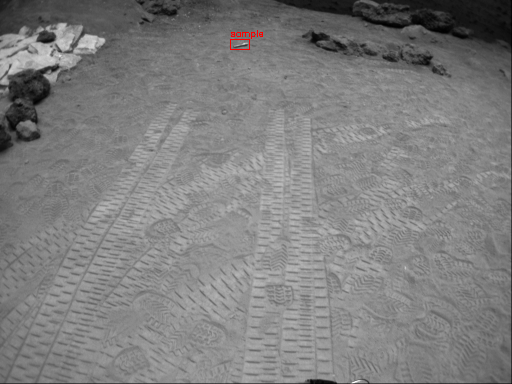

In [44]:
show_image_bbox(X_val_final, y_val_final, 5, 'transformed_image.png')

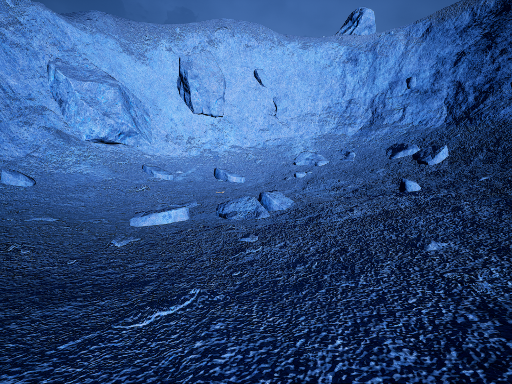

In [45]:
pil_img = tf.keras.utils.array_to_img(X_val_final[18])
pil_img

##**Salvar as imagens processadas e as novas obtidas de data augmentation numa nova pasta: organized_data**

In [46]:
!mkdir organized_data
!mkdir organized_data/train
!mkdir organized_data/train/X_train_images

!mkdir organized_data/valid
!mkdir organized_data/valid/X_valid_images

In [47]:
# criar duas dataframes para y_train e y_val e depois passar para csv file

dataframe_train = pd.DataFrame(y_train_final, columns=['x_center_norm',
                                                       'y_center_norm',
                                                       'width_norm', 'height_norm'])
dataframe_valid = pd.DataFrame(y_val_final, columns=['x_center_norm',
                                                     'y_center_norm',
                                                     'width_norm', 'height_norm'])

dataframe_train.to_csv('./organized_data/train/y_train', index=False)
dataframe_valid.to_csv('./organized_data/valid/y_val', index=False)

In [48]:
# armazenar as imagens dentro das novas pastas criadas para tal

for i, arr in enumerate(X_train_final):
  tf.keras.utils.save_img('./organized_data/train/X_train_images/processed_trainimage_' + str(i) + '.png', arr)

for i, arr in enumerate(X_val_final):
  tf.keras.utils.save_img('./organized_data/valid/X_valid_images/processed_validimage_' + str(i) + '.png', arr)